## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline

## Load Data

#### Training

In [2]:
X_train,Y_train,filenames_train = LoadBatch('data_batch_1')
Y_train_hot = one_hot(10,Y_train)
print(Y_train_hot.shape)

if False:
    w=25
    h=4
    X_visualize = X_train.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    visualize_multiple_images(X_visualize,h,w,True)

(10, 10000)


#### Test

In [3]:
X_test,Y_test,filenames_test = LoadBatch('test_batch')
Y_test_hot = one_hot(10,Y_test)
Y_test_hot.shape

(10, 10000)

#### Validation

In [4]:
X_valid,Y_valid,filenames_valid = LoadBatch('data_batch_2')
Y_valid_hot = one_hot(10,Y_valid)
Y_valid_hot.shape

(10, 10000)

## Preprocess

In [5]:
X_train=preprocess(X_train)
X_test=preprocess(X_test)
X_valid=preprocess(X_valid)
print(X_test.shape)

(3072, 10000)


## Layers

In [6]:
class Layer:
    
    #A building block. Each layer is capable of performing two things:
    #- Process input to get output:           output = layer.forward(input)
    #- Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    #Some layers also have learnable parameters which they update during layer.backward.
    
    def __init__(self):
        # Here we can initialize layer parameters (if any) and auxiliary stuff.
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [7]:
class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        self.fc = False # whether it is fully connected layer
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
#         return np.dot(grad_output,relu_grad)
        return grad_output*relu_grad

In [8]:
class Dense(Layer):
    """ Standard fully connected layer."""
    def __init__(self, input_units, output_units ):
        self.fc = True # whether it is fully connected layer
        self.ins = input_units
        self.outs = output_units
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(1/input_units), # Suggested  init
                                        size = (output_units, input_units))
#                        np.random.normal(loc=0.0, 
#                                         scale = np.sqrt(2/(input_units+output_units)), # He init
#                                         size = (output_units, input_units))
        self.biases = np.zeros(output_units)
        

    
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        # input shape: [input_units, batch]
        # output shape: [output units, batch]
        
        if input.ndim == 1:
            input = input.reshape(input.shape[0],1)
            
        return np.dot(self.weights, input) + self.biases[:,np.newaxis]
    
    def backward(self,input,grad_output,eta=0.001, regularization = 0.1):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        if input.ndim == 1:
            input = input.reshape(input.shape[0],1)
        grad_input = np.dot(self.weights.T, grad_output)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(grad_output, input.T)/(input.shape[1]) 
        if regularization:
            grad_weights += 2 * regularization * self.weights
            
        grad_biases = grad_output.mean(axis=1)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - eta * grad_weights
        self.biases = self.biases - eta * grad_biases
            
        return grad_input 

In [9]:
class Network():
    def __init__(self,layers = []):
        self.layers = layers[:]
        self.startup()
        
    def add(self,layer):
        self.layers.append(layer)
    
    def startup(self,n_epochs=40, n_batch=100, eta=0.001, reg=0.01, eta_min=None, eta_max=None, n_s=None):
        # Main param
        self.n_batch = n_batch
        self.eta = eta # learning rate
        self.reg = reg # regularization of weights
        
        ## Cyclic learning rate parameters
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.n_s = n_s
        self.t = 0 # nr of updates
        
        ## Logging
        self.train_acc_log = []
        self.val_acc_log = []
        self.train_loss_log = []
        self.val_loss_log = []
        self.train_cost_log = []
        self.val_cost_log = []
        self.eta_log = []
        self.t = 0
        
    def re_init(self):
        for l in self.layers:
            if l.fc:
                l.__init__(l.ins,l.outs)
                
    #############################################    
    ######## Cross Entropy loss function ########    
    def CrossEntropyLoss(self, softmax_input, P, Y_batch):
        lossgrad = -(Y_batch - P)
        tmp = np.exp(softmax_input)
        return lossgrad
    
    def SoftMax(self, input):
        tmp = np.exp(input)
        softmax = tmp / np.sum(tmp,0)[np.newaxis,:]
        return softmax
       
    def loss(self,X_batch, Y_batch):              
        activations = self.forward(X_batch)
        softmax_input = activations[-1]
        tmp = np.exp(softmax_input)
        loss_matrix = - softmax_input + np.log(np.sum(tmp,0))[np.newaxis,:]
        return (loss_matrix * Y_batch).sum()/Y_batch.shape[1]
    #############################################
    
    
    #############################################    
    ########           Logging           ########                  
    def logging(self, X_train, Y_train_hot, X_valid, Y_valid_hot, visualize, epoch):
        ll = 0
        for l in self.layers:
            if l.fc:
                ll +=self.reg*np.sum(l.weights[:]**2)
        self.train_acc_log.append(self.accuracy(X_train, Y_train_hot))
        self.val_acc_log.append(self.accuracy(X_valid, Y_valid_hot))
        self.train_loss_log.append(self.loss(X_train,Y_train_hot))
        self.val_loss_log.append(self.loss(X_valid,Y_valid_hot))
        self.train_cost_log.append(self.train_loss_log[-1] + ll)
        self.val_cost_log.append(self.val_loss_log[-1] + ll)
        if visualize:
            clear_output(wait="True")
        print("Epoch",epoch)
        print("Train accuracy:", self.train_acc_log[-1],"Train loss:","%.4f" % self.train_loss_log[-1] )
        print("Val accuracy:", self.val_acc_log[-1], "Val loss:", "%.4f" % self.val_loss_log[-1],"\n")
        if visualize:
            self.plot_training()
                
    def plot_training(self):
        fig, axs = plt.subplots(1,3, figsize=(15, 4))
        fig.subplots_adjust(hspace = .5, wspace=0.3)
        axs = axs.ravel()


        axs[0].plot(self.train_cost_log,label='train cost')
        axs[0].plot(self.val_cost_log,label='val cost')
        axs[0].legend(loc='best')
        axs[0].grid()
        
        axs[1].plot(self.train_loss_log,label='train loss')
        axs[1].plot(self.val_loss_log,label='val loss')
        axs[1].legend(loc='best')
        axs[1].grid()

        axs[2].plot(self.train_acc_log,label='train accuracy')
        axs[2].plot(self.val_acc_log,label='val accuracy')
        axs[2].legend(loc='best')
        axs[2].grid()
        plt.show()
    #############################################
    
    def forward(self, input):
        tmp = input
        activations = []
        activations.append(tmp)
        for l in self.layers:
            tmp = l.forward(activations[-1])
            activations.append(tmp)
        return activations
    
    def backward(self, X_batch, Y_batch):
        if Y_batch.ndim == 1:
            Y_batch = Y_batch.reshape(Y_batch.shape[0],1)
        activations = self.forward(X_batch)
        lossgrad = self.CrossEntropyLoss(activations[-1], self.SoftMax(activations[-1]), Y_batch)
        
        for i, l in reversed(list(enumerate(self.layers))):
            if l.fc:
                lossgrad = l.backward(activations[i], lossgrad, self.eta, self.reg)
            else:
                lossgrad = l.backward(activations[i],lossgrad)
    
    def predict(self, input):
        p = self.SoftMax(self.forward(input)[-1])
        return p.argmax(0)
    
    def accuracy(self, X, Y):
        Y_pred = self.predict(X)
        if Y.ndim == 2:
            Y = Y.argmax(0)
        return np.mean(Y_pred == Y)
    
    def cyclical_learning_rate(self):
        if self.eta_min and self.eta_max and self.n_s:
            self.eta = self.eta_min + np.copysign(np.mod(self.t,self.n_s),self.n_s-self.t)*(self.eta_max- self.eta_min)/self.n_s + (self.n_s<=self.t)*(self.eta_max-self.eta_min)
            self.eta_log.append(self.eta)

    def minibatch_SGD(self, X_train, Y_train_hot):
        n = X_train.shape[1]
        for j in range(0,n, self.n_batch):
                    self.cyclical_learning_rate() # updates the learning rate
                    X_batch = X_train[:, j:j+self.n_batch];
                    Y_batch = Y_train_hot[:, j:j+self.n_batch];
                    loss = self.backward(X_batch, Y_batch)
                    self.t = np.mod(self.t+1, 2*self.n_s) # increase update nr

                    
    def train(self, X_train, Y_train_hot, X_valid, Y_valid_hot, 
              shufle=True, n_epochs=40, n_batch=100, eta=0.001, reg=0.01, visualize=False, 
              eta_min=None, eta_max=None, n_s=None):
        
        # Delete old logging
        self.startup(n_epochs, n_batch, eta, reg, eta_min, eta_max, n_s)
        
        # Reiinit weighs
        self.re_init()
        
        for epoch in tqdm(range(n_epochs)):
            if shufle:
                X_train, Y_train_hot = shuffle(X_train,Y_train_hot) # shuffle

            ## Logging
            self.logging(X_train, Y_train_hot, X_valid, Y_valid_hot, visualize,epoch)         
            
            ## Minibatch SGD
            self.minibatch_SGD(X_train, Y_train_hot)
    

In [10]:
def shuffle(X,Y):
    indexes = np.random.permutation(X.shape[1])
    X = np.take(X,indexes,axis=1)
    Y = np.take(Y,indexes,axis=1)
    return X,Y

def create_val_set(X,Y,n_val=5000):
    X, Y = shuffle(X,Y)
    X_val = X[:,0:n_val]
    Y_val = Y[:,0:n_val]
    X = X[:,n_val:]
    Y = Y[:,n_val:]
    return X, Y, X_val, Y_val

### Define the Neural Network

In [11]:
n_in = X_train.shape[0]
n_out = 10
n_hidden = 50

nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


### Training

Epoch 49
Train accuracy: 0.6857 Train loss: 0.9872
Val accuracy: 0.4594 Val loss: 1.5602 



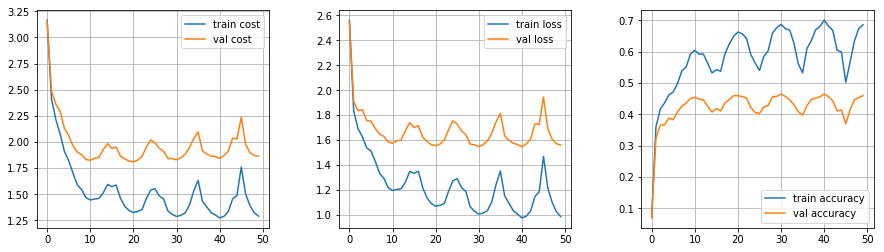

In [12]:
nn.train(X_train, Y_train_hot, X_valid, Y_valid_hot, 
         shufle = True, n_epochs=50, eta=0.001, reg = 0.01, visualize=True, 
         eta_min=1e-5, eta_max=1e-1,n_s=500)

In [13]:
print("Train set accuracy:",nn.accuracy(X_train,Y_train_hot))
print("Validation set accuracy:",nn.accuracy(X_valid,Y_valid_hot))
print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

Train set accuracy: 0.7056
Validation set accuracy: 0.4657
Test set accuracy: 0.4703


### Coarse-to-fine random search to set lambda

#### The data

In [8]:
X,Y=load_all_and_preproc()
Y = one_hot(10,Y)
X, Y, X_val, Y_val = create_val_set(X,Y)

print(X.shape,Y.shape, X_val.shape, Y_val.shape)

(3072, 45000) (10, 45000) (3072, 5000) (10, 5000)


#### The Neural Network

In [10]:
from NN import *
n_in, n = X.shape
n_out = 10
n_hidden = 50

nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))

#### Searching

In [27]:
n_s = 2*np.floor(n / 100)
l_min = -5
l_max = -3

data = []
for i in tqdm(range(20)):
    l = l_min + (l_max - l_min)*np.random.rand();
    reg = 10**l;
    nn.train(X, Y, X_val, Y_val, 
             shufle=True, n_epochs=4, reg=reg, visualize=False, 
             eta_min=1e-5, eta_max=1e-1,n_s=n_s)

    value = (reg,nn.accuracy(X_val,Y_val),nn.accuracy(X,Y))
    data.append(value)

column_name = ['lamba','val_acc','train_acc']
df = pd.DataFrame(data,columns=column_name)
df.to_csv("file"+str(l_min)+str(l_max) +".csv")

Epoch 0
Train accuracy: 0.12502222222222223 Train loss: 2.5188
Val accuracy: 0.1276 Val loss: 2.5132 

Epoch 1
Train accuracy: 0.4140888888888889 Train loss: 1.6990
Val accuracy: 0.3926 Val loss: 1.7632 

Epoch 2
Train accuracy: 0.4574888888888889 Train loss: 1.5388
Val accuracy: 0.4232 Val loss: 1.6331 

Epoch 3
Train accuracy: 0.5113777777777778 Train loss: 1.3836
Val accuracy: 0.4706 Val loss: 1.5146 

Epoch 0
Train accuracy: 0.12653333333333333 Train loss: 2.4641
Val accuracy: 0.1256 Val loss: 2.4664 

Epoch 1
Train accuracy: 0.38982222222222224 Train loss: 1.7765
Val accuracy: 0.3736 Val loss: 1.8354 

Epoch 2
Train accuracy: 0.4434222222222222 Train loss: 1.5596
Val accuracy: 0.4092 Val loss: 1.6537 

Epoch 3
Train accuracy: 0.5199555555555555 Train loss: 1.3651
Val accuracy: 0.4772 Val loss: 1.5061 

Epoch 0
Train accuracy: 0.10848888888888888 Train loss: 2.4976
Val accuracy: 0.1104 Val loss: 2.5040 

Epoch 1
Train accuracy: 0.42846666666666666 Train loss: 1.6314
Val accuracy: 0

#### Visualization

    Unnamed: 0     lamba  val_acc  train_acc
7            7  0.000035   0.4814   0.555467
9            9  0.000019   0.4848   0.553244
13          13  0.000361   0.4876   0.557622
18          18  0.000055   0.4890   0.556022
8            8  0.000218   0.4894   0.556089
11          11  0.000371   0.4898   0.553400
2            2  0.000025   0.4900   0.558067
1            1  0.000091   0.4902   0.552978
6            6  0.000104   0.4906   0.553978
14          14  0.000499   0.4912   0.552556
0            0  0.000066   0.4932   0.555044
3            3  0.000948   0.4934   0.556644
12          12  0.000048   0.4936   0.553689
16          16  0.000893   0.4938   0.552267
5            5  0.000368   0.4938   0.555489
15          15  0.000085   0.4952   0.556644
10          10  0.000014   0.4962   0.556644
19          19  0.000075   0.4972   0.558511
4            4  0.000025   0.4978   0.556067
17          17  0.000470   0.4988   0.554933


[]

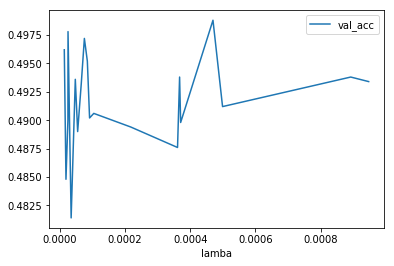

In [15]:
df =pd.read_csv('file-5-3.csv')
df2=df.sort_values('lamba')
print(df2.sort_values('val_acc'))

df2.plot(x='lamba', y='val_acc')
plt.plot()

### Proper Training

Epoch 22
Train accuracy: 0.4844 Train loss: 1.5478
Val accuracy: 0.411 Val loss: 1.8934 



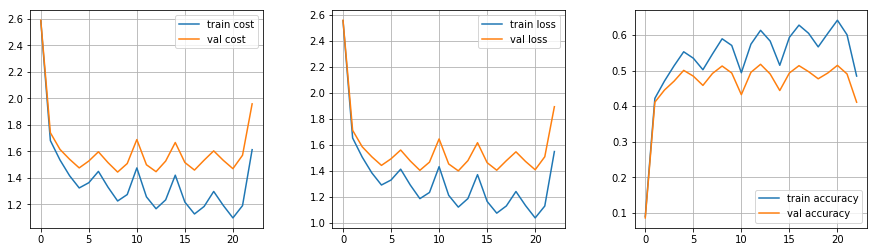

In [ ]:
X,Y=load_all_and_preproc()
Y = one_hot(10,Y)
X, Y, X_val, Y_val = create_val_set(X,Y)

print(X.shape,Y.shape, X_val.shape, Y_val.shape)

n_in, n = X.shape
n_out = 10
n_hidden = 50

nn = Network()
nn.add(Dense(n_in, n_hidden))
nn.add(ReLU())
nn.add(Dense(n_hidden, n_out))


nn.train(X, Y, X_val, Y_val, 
         shufle = True, n_epochs=32, eta=0.001, reg = 0.000470, visualize=True, 
         eta_min=1e-5, eta_max=1e-1,n_s=900)

In [ ]:
print("Train set accuracy:",nn.accuracy(X,Y))
print("Validation set accuracy:",nn.accuracy(X_val,Y_val))
print("Test set accuracy:",nn.accuracy(X_test,Y_test_hot))

#### Visualize the cyclical learning rate

1e-05


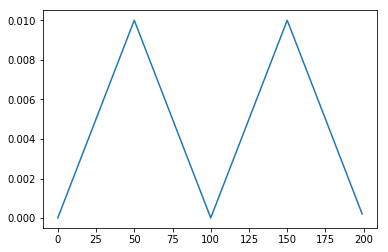

In [369]:
eta_min=1e-5
eta_max=1e-2
lamda=0.01
n_s=50
def funcc(t):
    t = np.mod(t,2*n_s)
    eta = eta_min + np.copysign(np.mod(t,n_s),n_s-t)*(eta_max- eta_min)/n_s + (n_s<=t)*(eta_max-eta_min)
    return eta

aa = np.arange(200)
xx = []
for t in aa:
    xx.append(funcc(t))
#xx = funcc(aa)
plt.plot(aa,xx)
print(xx[0])